In [165]:
import gym
import numpy as np
import collections
import random

from keras.models import Model
from keras.layers import Input, Dense
from keras.optimizers import Adam
from keras import backend as K

import matplotlib.pyplot as plt

import tensorflow as tf

%matplotlib inline

In [166]:
class SineEnv(gym.Env):
    
    def __init__(self, n=1000):
        
        self.n = n
        self.num_actions = 3
        self.series = 3 + np.sin(0.01* np.arange(self.n))
        self.done = False
        self.action_space = gym.spaces.Discrete(self.num_actions)
    
    def step(self, action):
        
        self.index += 1
        obs = self.series[self.index]
        step_return = np.log(self.series[self.index]/self.series[self.index-1])
        reward = (action - 1) * step_return
        
        if self.index >= (self.n-1):
            self.done = True
            
        info = {
            'return': step_return
        }
        return obs, reward, self.done, info
        
    def reset(self):
        self.index = 0
        self.done = False
        obs = self.series[self.index]
        return obs

In [180]:
class PolicyGradientAgent(object):
    
    def __init__(self, num_actions=3, replay_buffer_size=1000, stack_size=8, l=96, n=10, train_period=20):
        
        self.num_actions = num_actions
        self.replay_buffer_size = replay_buffer_size
        self.stack_size = stack_size
        self._replay = collections.deque(maxlen=self.replay_buffer_size)
        
        self.series = []
        self.n = n
        self.l = l
        
        self.steps = 0
        self.model = self._build_model()


    def path_score(self, path):
        """Path is a list of tuples, each tuple is a state, action pair [(s, a), (s, a)]
        Returns the sums of the rewards for the path using the current policy"""
        
        path_reward = 0
        for path_step in path:
            for experience in self._replay:
                if path_step == (experience[0], experience[1]):
                    path_reward += experience[2]
        
        return path_reward
        
    def log_prob(self, state, action):
        p = K.log(self.model(state))
        p = K.slice(p, [action], [1])
        return p
    
    def path_loss(self, path):
        path_loss = K.constant(0)
        for step in path:
            state = step[0]
            action = step[1]
            path_loss += self.log_prob(state, action)
            
        path_loss *= self.path_score(path)
        path_loss = -path_loss
        
        return path_loss
    
    def build_path(self, start_state):
        
        path = []
        state = start_state
        action = self._select_action(state)

        path.append((state, action))
        length = 1
        
        while length < self.l:
            for experience in self.replay:
                if (state, action) == (experience[0], experience[1]):
                    state = experience[3]
                    action = self._select_action(state)
                    length += 1
                    path.append((state, action))
            
        return self.path_loss(path)
        

    def loss_computation(self):
        l = K.constant(0)
        samples_index = random.sample(range(len(self._replay) - self.l), self.n)
        print(samples_index)

        for i in samples_index:
            print("Current_index: {}".format(i))
            experience = self._replay[i]
            start_state = experience[0]
            l += self.build_path(start_state)

        l = l/self.n
            
        return l
    
    def loss_keras(self):
        
        def loss(y_true, y_pred):
            l = self.loss_computation()
            return l
        
        return loss

    
    def _train_step(self):
        
        # Train whenever a multiple of train_period
        if (self.steps % self.train_period) == 0 and (len(self._replay) >= max(self.n, self.l)):
            tensor2 = K.const(np.random.randn((8,2)))
            tensor = K.const(np.array([1,2,3]))
            self.model.fit(tensor2, tensor)
        

    def _build_model(self):
        
        inputs = Input(shape=(self.stack_size,))
        X = Dense(64, activation='relu')(inputs)
        X = Dense(64, activation='relu')(X)
        predictions = Dense(self.num_actions, activation='softmax')(X)
        
        model = Model(inputs=inputs, outputs=predictions)
        loss = self.loss_keras()
        model.compile(optimizer='adam', loss=loss)
        
        return model
    
    def initialise_episode(self, observation):
        self.series.extend([observation] * self.stack_size)
        self.state = self.construct_state(observation)
        return self._select_action(self.state)
    
    def construct_state(self, observation):
        self.series.append(observation)
        log_ret = np.log((np.array(self.series[1:]))/(np.array(self.series[:-1])))
        return log_ret[-self.stack_size:]
    
    def step(self, reward, observation):
        self.current_state = self.construct_state(observation)
        experience = (self.state, self.action, reward, self.current_state)
        self._replay.append(experience)
        self.state = self.current_state
        self.steps += 1
        
        # Train the model
        self._train_step()
        return self._select_action(self.state)
    
    def _select_action(self, state):
        state_tensor = tf.convert_to_tensor(state, dtype=tf.float32)
        state_tensor = tf.reshape(state_tensor, shape=(1, self.stack_size))

        action_prob_values = K.eval(self.model(state_tensor))
        print("Action prob values: {}".format(action_prob_values))
        self.action = np.random.choice(a=np.arange(self.num_actions), p=action_prob_values[0])
        return self.action

In [181]:
env = SineEnv(n=1000)
agent = PolicyGradientAgent()

ValueError: Sample larger than population or is negative

In [172]:
obs = env.reset()
done = False

observations = []
action = agent.initialise_episode(obs)

agent_rewards = []
benchmark_rewards = []

while not done:
    obs, reward, done, info = env.step(action)
    agent_rewards.append(reward)
    benchmark_rewards.append(info['return'])
    if not done:
        action = agent.step(reward, obs)

Action prob values: [[0.33333334 0.33333334 0.33333334]]
Action prob values: [[0.33348563 0.33326626 0.33324805]]
Action prob values: [[0.33336577 0.33330396 0.33333027]]
Action prob values: [[0.33346197 0.33338934 0.33314866]]
Action prob values: [[0.3335409  0.33334595 0.33311316]]
Action prob values: [[0.3335725  0.33333716 0.33309036]]
Action prob values: [[0.33360684 0.3334612  0.3329319 ]]
Action prob values: [[0.33359668 0.33345664 0.33294672]]
Action prob values: [[0.33354747 0.3335061  0.33294642]]
Action prob values: [[0.33354664 0.33350548 0.33294788]]
Action prob values: [[0.3335458  0.33350483 0.3329494 ]]
Action prob values: [[0.3335449  0.33350414 0.33295092]]
Action prob values: [[0.33354405 0.33350345 0.33295247]]
Action prob values: [[0.33354318 0.3335028  0.33295408]]
Action prob values: [[0.33354226 0.33350208 0.33295566]]
Action prob values: [[0.33354136 0.33350137 0.3329573 ]]
Action prob values: [[0.3335404  0.33350062 0.33295894]]
Action prob values: [[0.3335395

KeyboardInterrupt: 

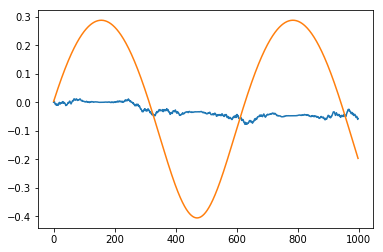

In [68]:
plt.plot(np.cumsum(agent_rewards))
plt.plot(np.cumsum(benchmark_rewards))

In [67]:
agent_rewards

[0.0,
 0.003316366504332892,
 0.0,
 -0.00329287248224624,
 -0.0032807539279420604,
 -0.0032683924580139976,
 0.0,
 0.0,
 -0.0032298858318851437,
 0.0032165878111498707,
 0.0,
 -0.003189318567616955,
 0.0,
 0.0,
 0.0031467818413767564,
 -0.0031321806349846053,
 0.00311737365092575,
 0.003102364060013224,
 0.0,
 0.0030717495675277174,
 -0.0030561508341639928,
 -0.003040361830362619,
 0.003024385553510366,
 0.0,
 0.0,
 0.0,
 0.0029586664525747012,
 -0.0029417975615126063,
 0.00292475865698327,
 0.0,
 0.0028901818002611264,
 -0.002872649259740262,
 0.0,
 -0.002837109231115252,
 0.002819106953446421,
 -0.0028009532518951706,
 0.0,
 0.0,
 -0.0027456086668977133,
 -0.0027268741702648376,
 -0.0027080005382589287,
 0.0026889901323595075,
 0.0,
 0.0,
 0.0,
 0.0026116269017221576,
 0.0025919669544558527,
 0.00257218374937059,
 0.0,
 -0.0025322561215376667,
 0.002512115902876299,
 0.0024918608351444252,
 0.002471492947875931,
 0.0,
 -0.002430426690799959,
 -0.0024097322388941774,
 -0.0023889328038

In [106]:
np.random.choice(np.arange(3), p=np.array([0.2, 0.6, 0.2]))

1

In [122]:
ar1 = np.arange(10)
ar1

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [118]:
ar2 = np.arange(2,7)
ar2

array([2, 3, 4, 5, 6])

In [123]:
ar1[1:]/ar1[:-1]

/Users/sushantkumar/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:1: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':


array([       inf, 2.        , 1.5       , 1.33333333, 1.25      ,
       1.2       , 1.16666667, 1.14285714, 1.125     ])

In [124]:
l1 = [1,2]

In [142]:
np.array(l1)

some_tensor = tf.convert_to_tensor(np.arange(8), dtype=tf.float32)

In [148]:
reshaped_tensor = tf.reshape(some_tensor, shape=(1,8))

In [149]:
agent.model(reshaped_tensor)

<tf.Tensor 'model_14_4/dense_42/Softmax:0' shape=(1, 3) dtype=float32>

In [158]:
np.random.randn(2,8).shape

(2, 8)